In [2]:
%reset -f

In [3]:
#imports
import pandas as pd
import numpy as np
import nltk
import re
import os
from tqdm import tqdm, tqdm_pandas
#tqdm_pandas(tqdm())
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt 
import matplotlib as mpl

def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return
setup_mpl()

# Text preprocessing

The preprocessing of the text is done through the Porter stemmer, which stems all words, i.e., converts words to their stem by removing common endings from words. Afterwards, any stopwords - the most common, non-meaningful words such as "a", "the", etc. - are removed, while any words containing non alphabetical characters are removed and urls are converted to the common string, "URL". 

In [15]:
# Preprocessing function

porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()

# Keep numbers / Remove numbers / Substitute numbers with token


def preprocess(text):
    #Common english stop words
    stop_words = set(stopwords.words('english'))
    # Substituting urls with 
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    text = re.sub(r'http\S+', '#URL#', str(text)) # Maybe change to single-character-symbol -> shingles
    #Tokenize using nltk
    word_tokens = word_tokenize(text.lower())
    #removing none letter characters and stop words
    filtered_sentence = [w for w in word_tokens if w not in stop_words and w.isalpha()]
    #Conduct stemming
    processed_text = [porter.stem(t) for t in filtered_sentence]
    return processed_text

Then the clean CSV.-files are created, ready to be used for data analysis and as input to machine learning models. 

### SMS spam: 

In [5]:
PATH = "../data/regular/spam.csv"
SMS = pd.read_csv(PATH)[['v1','v2']]
SMS = SMS.rename(columns={'v1': 'label', 'v2': 'text'})

label = SMS['label'].values
text = SMS['text'].values

In [6]:
SMS['tokens'] = [preprocess(x) for x in tqdm(SMS['text'])]
SMS['str_tokens'] = [' '.join(x) for x in tqdm(SMS['tokens'])]
# Removing rows of emtpty tokens
SMS = SMS[SMS['tokens'].astype(bool)]
binary_dict = {'ham': 0, 'spam': 1}
SMS['binary'] = [binary_dict[x] for x in tqdm(SMS['label'])]
SMS.to_csv('../data/clean/clean_spam.csv', index=False)


100%|██████████| 5551/5551 [00:00<00:00, 2184516.94it/s]


### Email spam

In [7]:
PATH = "../data/regular/completeSpamAssassin.csv"
EMAIL = pd.read_csv(PATH, index_col = 'Unnamed: 0')

EMAIL.rename(columns = {'Label':'label', 'Body':'text'}, inplace = True)

EMAIL['label'] = EMAIL['label'].replace(0, 'ham')
EMAIL['label'] = EMAIL['label'].replace(1, 'spam')

# Removing 'empty' rows
EMAIL.text = np.where(EMAIL.text.isin(['empty']), np.nan, EMAIL.text)
EMAIL = EMAIL.dropna().reset_index().drop(columns=['index'])

In [8]:
EMAIL['tokens'] = [preprocess(x) for x in tqdm(EMAIL['text'])]
EMAIL['str_tokens'] = [' '.join(x) for x in tqdm(EMAIL['tokens'])]
EMAIL = EMAIL[EMAIL['tokens'].astype(bool)]
binary_dict = {'ham': 0, 'spam': 1}
EMAIL['binary'] = [binary_dict[x] for x in tqdm(EMAIL['label'])]
EMAIL.to_csv('../data/clean/clean_completeSpamAssassin.csv', index=False)

100%|██████████| 5507/5507 [00:00<00:00, 1789158.18it/s]


In [9]:
EMAIL

,text,label,tokens,str_tokens,binary
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,spam,"[save, life, insur, spend, life, quot, save, e...",save life insur spend life quot save ensur fam...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam,"[fight, risk, cancer, url, slim, guarante, los...",fight risk cancer url slim guarante lose lb da...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam,"[fight, risk, cancer, url, slim, guarante, los...",fight risk cancer url slim guarante lose lb da...,1
3,##############################################...,spam,"[adult, club, offer, free, membership, instant...",adult club offer free membership instant acces...,1
4,I thought you might like these:\n1) Slim Down ...,spam,"[thought, might, like, slim, guarante, lose, l...",thought might like slim guarante lose lb day u...,1
...,...,...,...,...,...
5507,----------------------------------------------...,ham,"[isilo, tm, palm, os, pocket, pc, window, ente...",isilo tm palm os pocket pc window enter isilo ...,0
5508,"EFFector Vol. 15, No. 35 November ...",ham,"[effector, vol, novemb, ren, public, electron,...",effector vol novemb ren public electron fronti...,0
5509,\nWe have extended our Free seat sale until Th...,ham,"[extend, free, seat, sale, thursday, novemb, d...",extend free seat sale thursday novemb detail s...,0
5510,___ ___ ...,ham,"[insignific, matter, heavili, overemphasis, hu...",insignific matter heavili overemphasis hugh mt...,0


# Data Analysis

In [2]:
%reset -f

#imports
import pandas as pd
import numpy as np
import nltk
import re
import os
from tqdm import tqdm, tqdm_pandas
#tqdm_pandas(tqdm())
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Sources
https://www.researchgate.net/figure/Average-daily-number-of-base-stations-visited-by-spammers-red-legitimate-customers_fig1_262330820
https://towardsdatascience.com/spam-detection-in-sms-messages-3322e03300f5


# Data Analysis

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return
setup_mpl()

The following analysis will investigate the nature of the spam/ham dataset. More specifically, we will look into how long the typical SMS/email is for each group respectively. Subsequently, we will investigate the amount of spelling mistakes present in each group.

In [7]:
from ast import literal_eval

datasets = ['clean_spam.csv', 'clean_completeSpamAssassin.csv'] #, 'clean_Job_postings.csv', 'clean_NEWS.csv']

dfs = {'clean_spam.csv': {'data': [], 'spam': [], 'ham': [], 'type': 'SMS'},
       'clean_completeSpamAssassin.csv': {'data': [], 'spam': [], 'ham': [], 'type': 'E-mail'},
      }
       #'clean_Job_postings.csv': {'data': [], 'fraudulent': [], 'genuine': [], 'type': 'Job postings'},
       #'clean_NEWS.csv': {'data': [], 'fake': [], 'real': [], 'type': 'News'}}

for dataset in datasets:
    
    # read data
    df = pd.read_csv('../data/clean/' + dataset, encoding= "ISO-8859-1")

    df.tokens = df.tokens.apply(literal_eval)
    df['len'] = df.tokens.str.len()
    
    # Saving data, and the classes into dictionary
    dfs[dataset]['data'] = df
    dfs[dataset][list(dfs[dataset].keys())[1]] = df[df.label==list(dfs[dataset].keys())[1]]
    dfs[dataset][list(dfs[dataset].keys())[2]] = df[df.label==list(dfs[dataset].keys())[2]]

First let us investigate the proportion of ham and spam in the datasets:

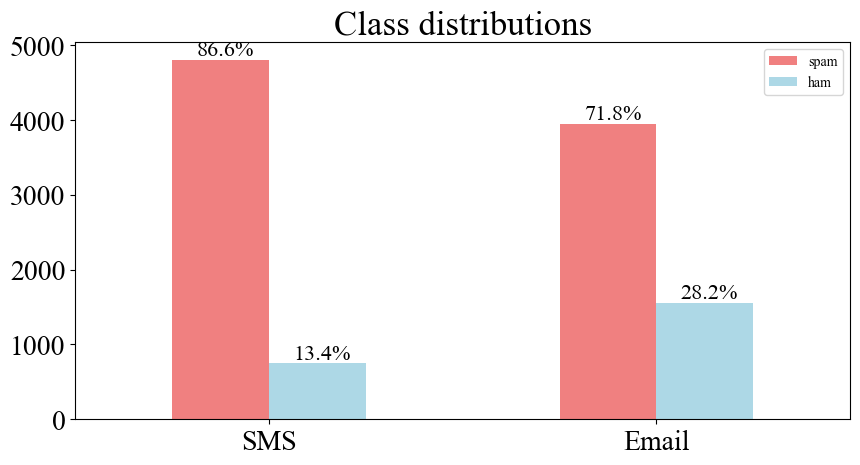

In [9]:
total = []
spam_counts = []
ham_counts = []
for i in range(2):
    total.append(dfs[datasets[i]]['data'].label.value_counts()[0] + dfs[datasets[i]]['data'].label.value_counts()[1])
    spam_counts.append(dfs[datasets[i]]['data'].label.value_counts()[0])
    ham_counts.append(dfs[datasets[i]]['data'].label.value_counts()[1])    
    
from matplotlib.pyplot import figure

# figure(figsize=(20, 10), dpi=100)
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.dpi"] = 100


index = ['SMS', 'Email']
df = pd.DataFrame({'spam': spam_counts, 'ham': ham_counts}, index=index)
ax = df.plot.bar(rot=0, color=['lightcoral', 'lightblue'])
       
for i, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * p.get_height()/total[i%2])
    x = p.get_x() + p.get_width() / 4
    y = p.get_y() + p.get_height() + 60
    ax.annotate(percentage, (x, y), fontsize = 16)  
    ax.tick_params(axis='x', which='both', labelsize=20)
    ax.tick_params(axis='y', which='both', labelsize=20)  
    
plt.title('Class distributions', size = 25)
plt.show()


Getting actual counts of classes

In [10]:
for dataset in datasets:
    print('Dataset:', dataset)
    print(dfs[dataset]['data'].label.value_counts(), "\n")

Dataset: clean_spam.csv
ham     4805
spam     746
Name: label, dtype: int64 

Dataset: clean_completeSpamAssassin.csv
ham     3952
spam    1555
Name: label, dtype: int64 



In [11]:
print("Total observations SMS", 4825 + 747) #5572
print("Total observations Email", 3952 + 1560) # 5512


Total observations SMS 5572
Total observations Email 5512


Notably, the dataset illustrated a significant class imbalance, which would probably have to be taken into account when training models for classification.

The following will analyse the length distribution of spam and ham mails:

Checking for log normality in the text length through Q-Q plots. 

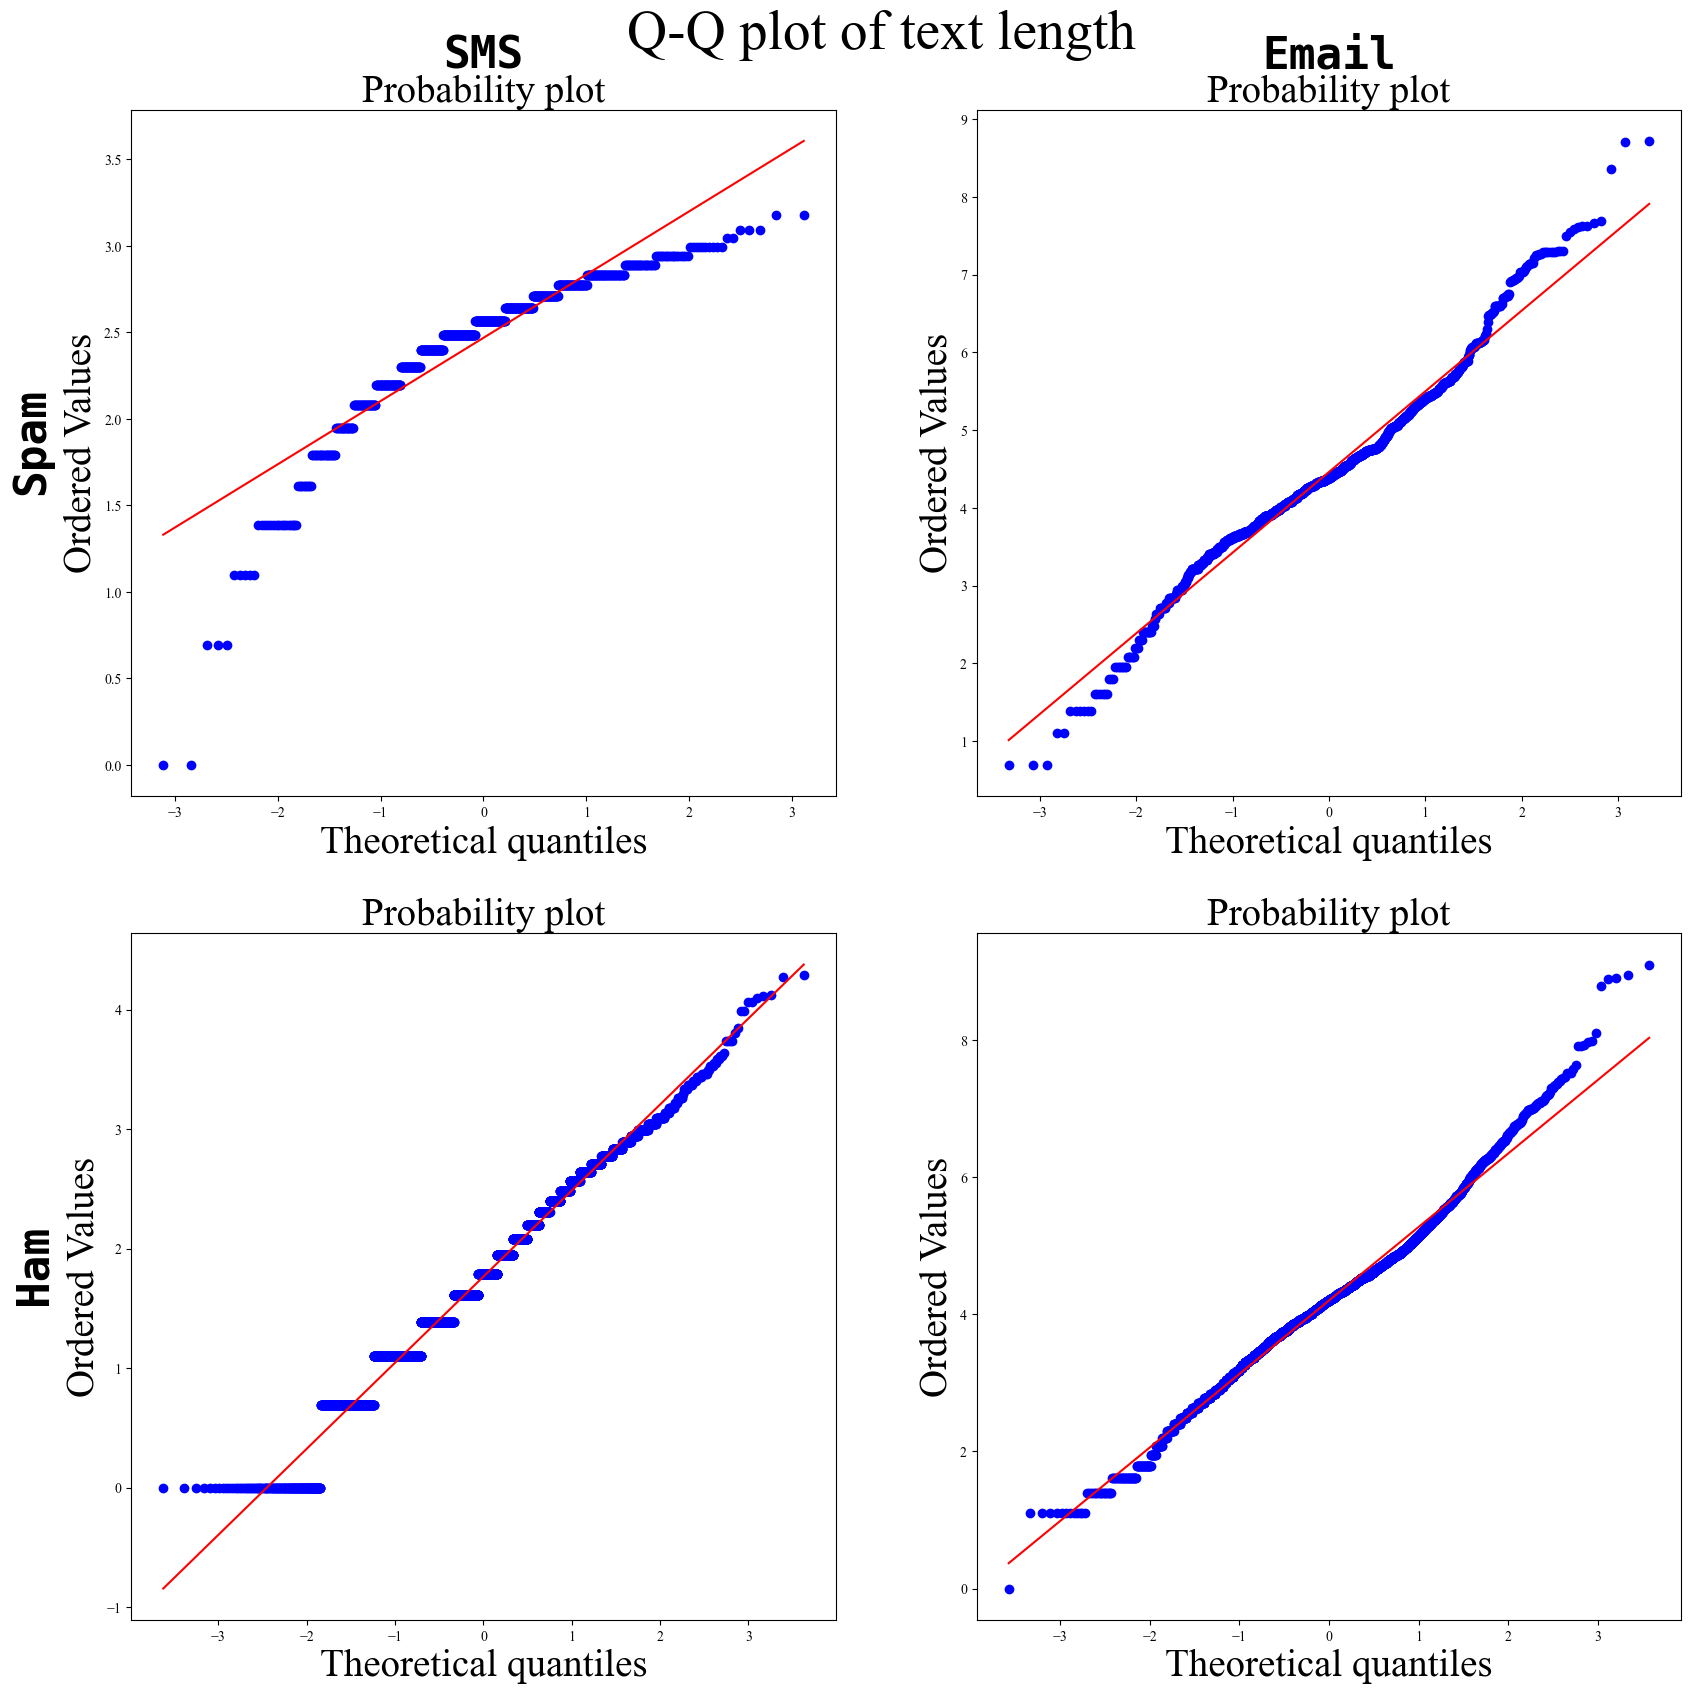

In [12]:
import pylab
import scipy.stats


def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1.05),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(-0.1, 0.55),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 20), dpi=100)

datasets = ['clean_spam.csv', 'clean_completeSpamAssassin.csv']*2
label = ['spam', 'spam', 'ham', 'ham']

col_headers = ['SMS', 'Email']
row_headers = ['Spam', 'Ham']


for i, ax in enumerate(axs.flat):
    measurements = np.log(list(dfs[datasets[i]][label[i]].len.values))
    scipy.stats.probplot(measurements, dist="norm", plot=ax)
    ax.set_title("Probability plot", fontsize = 28)
    ax.set_xlabel("Theoretical quantiles", fontsize=28)
    ax.set_ylabel("Ordered Values", fontsize=28)


font_kwargs = dict(fontfamily="monospace", fontweight="bold", size=32)
add_headers(fig, col_headers=col_headers, row_headers=row_headers, **font_kwargs)

fig.suptitle('Q-Q plot of text length', size = 40, y=0.93)
plt.show()

Since the observations in the Email dataset follow the red line quite nicely, the distribution is said to follow a log normal distribution. Thus the email dataset will be plotted in log-scale in the following plots.

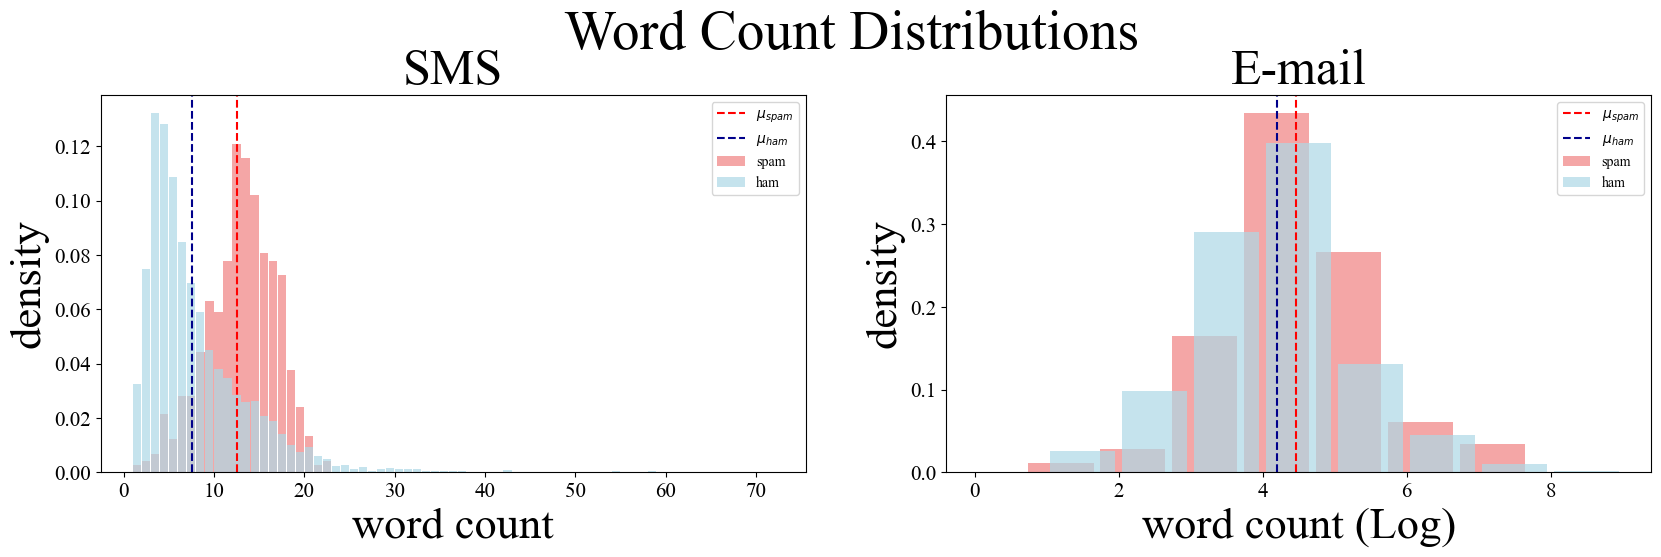

In [20]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5), dpi=100)
fig.subplots_adjust(hspace=0.3)

spam_lens = []
ham_lens = []


for i, ax in enumerate(axs.flat):

    # Accessing correct dataset, and getting word count 
    
    spam_label = list(dfs[datasets[i]].keys())[1]
    ham_label = list(dfs[datasets[i]].keys())[2]
    
    
    if i == 1:
        spam_len = np.log(list(dfs[datasets[i]][spam_label].len.values))
        ham_len = np.log(list(dfs[datasets[i]][ham_label].len.values))
    else:
        spam_len = list(dfs[datasets[i]][spam_label].len.values)
        ham_len = list(dfs[datasets[i]][ham_label].len.values)
        
    spam_lens.append(spam_len)
    ham_lens.append(ham_len)

    bins = np.arange(min(spam_len), max(spam_len), 1)
    hist, edges = np.histogram(spam_len, bins=bins, density=True)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1]-bins[0]

    ax.bar(x, hist, width=width*0.91, color='lightcoral', label=spam_label, alpha=0.7)
    ax.set_ylabel("counts")
    ax.set_xlabel("k")
    ax.set_title("")
    
    ax.axvline(np.mean(spam_len), c='red', label='$\mu_{'+spam_label+'}$', linestyle='dashed')
    ax.axvline(np.mean(ham_len), c='darkblue', label='$\mu_{'+ham_label+'}$', linestyle='dashed')

    bins = np.arange(min(ham_len), max(ham_len), 1)
    hist, edges = np.histogram(ham_len, bins=bins, density=True)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1]-bins[0]
    ax.bar(x, hist, width=width*0.90, color='lightblue', label=ham_label, alpha=0.7)
    ax.tick_params(axis='x', which='both', labelsize=15)
    ax.tick_params(axis='y', which='both', labelsize=15)    

    ax.legend()
    ax.set_ylabel("density", fontsize = 32)
    
    if str(dfs[datasets[i]]['type']) == 'E-mail':
        ax.set_xlabel("word count (Log)", fontsize = 32)
    
    else: 
        ax.set_xlabel("word count", fontsize = 32)
    
    ax.set_title(str(dfs[datasets[i]]['type']), fontsize = 36) #TODO: maybe change to number of words
    
  

plt.suptitle("Word Count Distributions", fontsize = 40, y=1.05)
plt.show()

By visually inspecting the above figure, it appears that spam SMSes tend to have longer content than ham SMSes.
Visually, it is difficult to tell with the other datasets, the following will print the mean and standard deviations useed to create the plots:

In [22]:
for i, dataset in enumerate(datasets[:2]):
    
    print('Dataset:', dataset)
    print()
    print(f'Mean of spam: {np.mean(spam_lens[i])}')
    print(f'Standard deviation of spam: {np.std(spam_lens[i])}')
    print()
    print(f'Mean of ham: {np.mean(ham_lens[i])}')
    print(f'Standard deviation of ham: {np.std(ham_lens[i])}')
    print()
    print()

Dataset: clean_spam.csv

Mean of spam: 12.57372654155496
Standard deviation of spam: 3.8609277108605977

Mean of ham: 7.56108220603538
Standard deviation of ham: 6.004461095151682


Dataset: clean_completeSpamAssassin.csv

Mean of spam: 4.460125620197719
Standard deviation of spam: 1.0482585579346877

Mean of ham: 4.199805870951014
Standard deviation of ham: 1.0770224601413823




Clearly SMSes are of much smaller word count than Emails, not surprisingly, as SMSes tend to be less formal than the written text contained in the other datasets.

Interestingly, the word count of emails have a much higher standard deviation than SMS messages.

The mean and standard deviations within the datasets, do not seem to depend much on whether the text contains spam or ham.

## Spelling mistakes

Furthermore, the following will investigate the proportion of spelling mistakes in each group respectively.

In [23]:
from spellchecker import SpellChecker
import re
import nltk
from tqdm import tqdm

tqdm.pandas()
spell = SpellChecker()

def find_misspelled(row, spell):

    text = row.text.lower()
    words = nltk.tokenize.word_tokenize(text)

    misspelled = [word for word in spell.unknown(words) if str(word) not in ['nan']]
    return misspelled

Finding all misspelled words, and the ratio of which words in a sentence are misspelled. 

In [24]:
spell = SpellChecker()

for dataset in datasets[:2]:
    dfs[dataset]['data']['misspelled'] = dfs[dataset]['data'].progress_apply(lambda row: find_misspelled(row, spell), axis=1)
    dfs[dataset]['data']['misspelled_size'] = dfs[dataset]['data']['misspelled'].apply(lambda x: len(x))

    # Ratio of misspelled words
    dfs[dataset]['data']['misspell_ratio'] = dfs[dataset]['data']['misspelled_size'] / dfs[dataset]['data']['len']
    
    # Saving dataframe per class again
    dfs[dataset][list(dfs[dataset].keys())[1]] = dfs[dataset]['data'][dfs[dataset]['data']['label'] == list(dfs[dataset].keys())[1]]
    dfs[dataset][list(dfs[dataset].keys())[2]] = dfs[dataset]['data'][dfs[dataset]['data']['label'] == list(dfs[dataset].keys())[2]]    

100%|██████████| 5507/5507 [00:14<00:00, 385.34it/s] 


In [25]:
# Ratio in total data:
for dataset in datasets[:2]:
    
    print("Total ratio of spam misspellings in", dataset+":", np.sum(dfs[dataset]['spam']['misspelled_size']) / np.sum(dfs[dataset]['spam']['len']))
    print("Total ratio of ham misspellings in", dataset+":", np.sum(dfs[dataset]['ham']['misspelled_size']) / np.sum(dfs[dataset]['ham']['len']))    

Total ratio of spam misspellings in clean_spam.csv: 0.3549040511727079
Total ratio of ham misspellings in clean_spam.csv: 0.24040075968181443
Total ratio of spam misspellings in clean_completeSpamAssassin.csv: 0.1577784753467499
Total ratio of ham misspellings in clean_completeSpamAssassin.csv: 0.21005309046714657


Once again doing Q-Q plots, this time for the misspelling count within data sets.

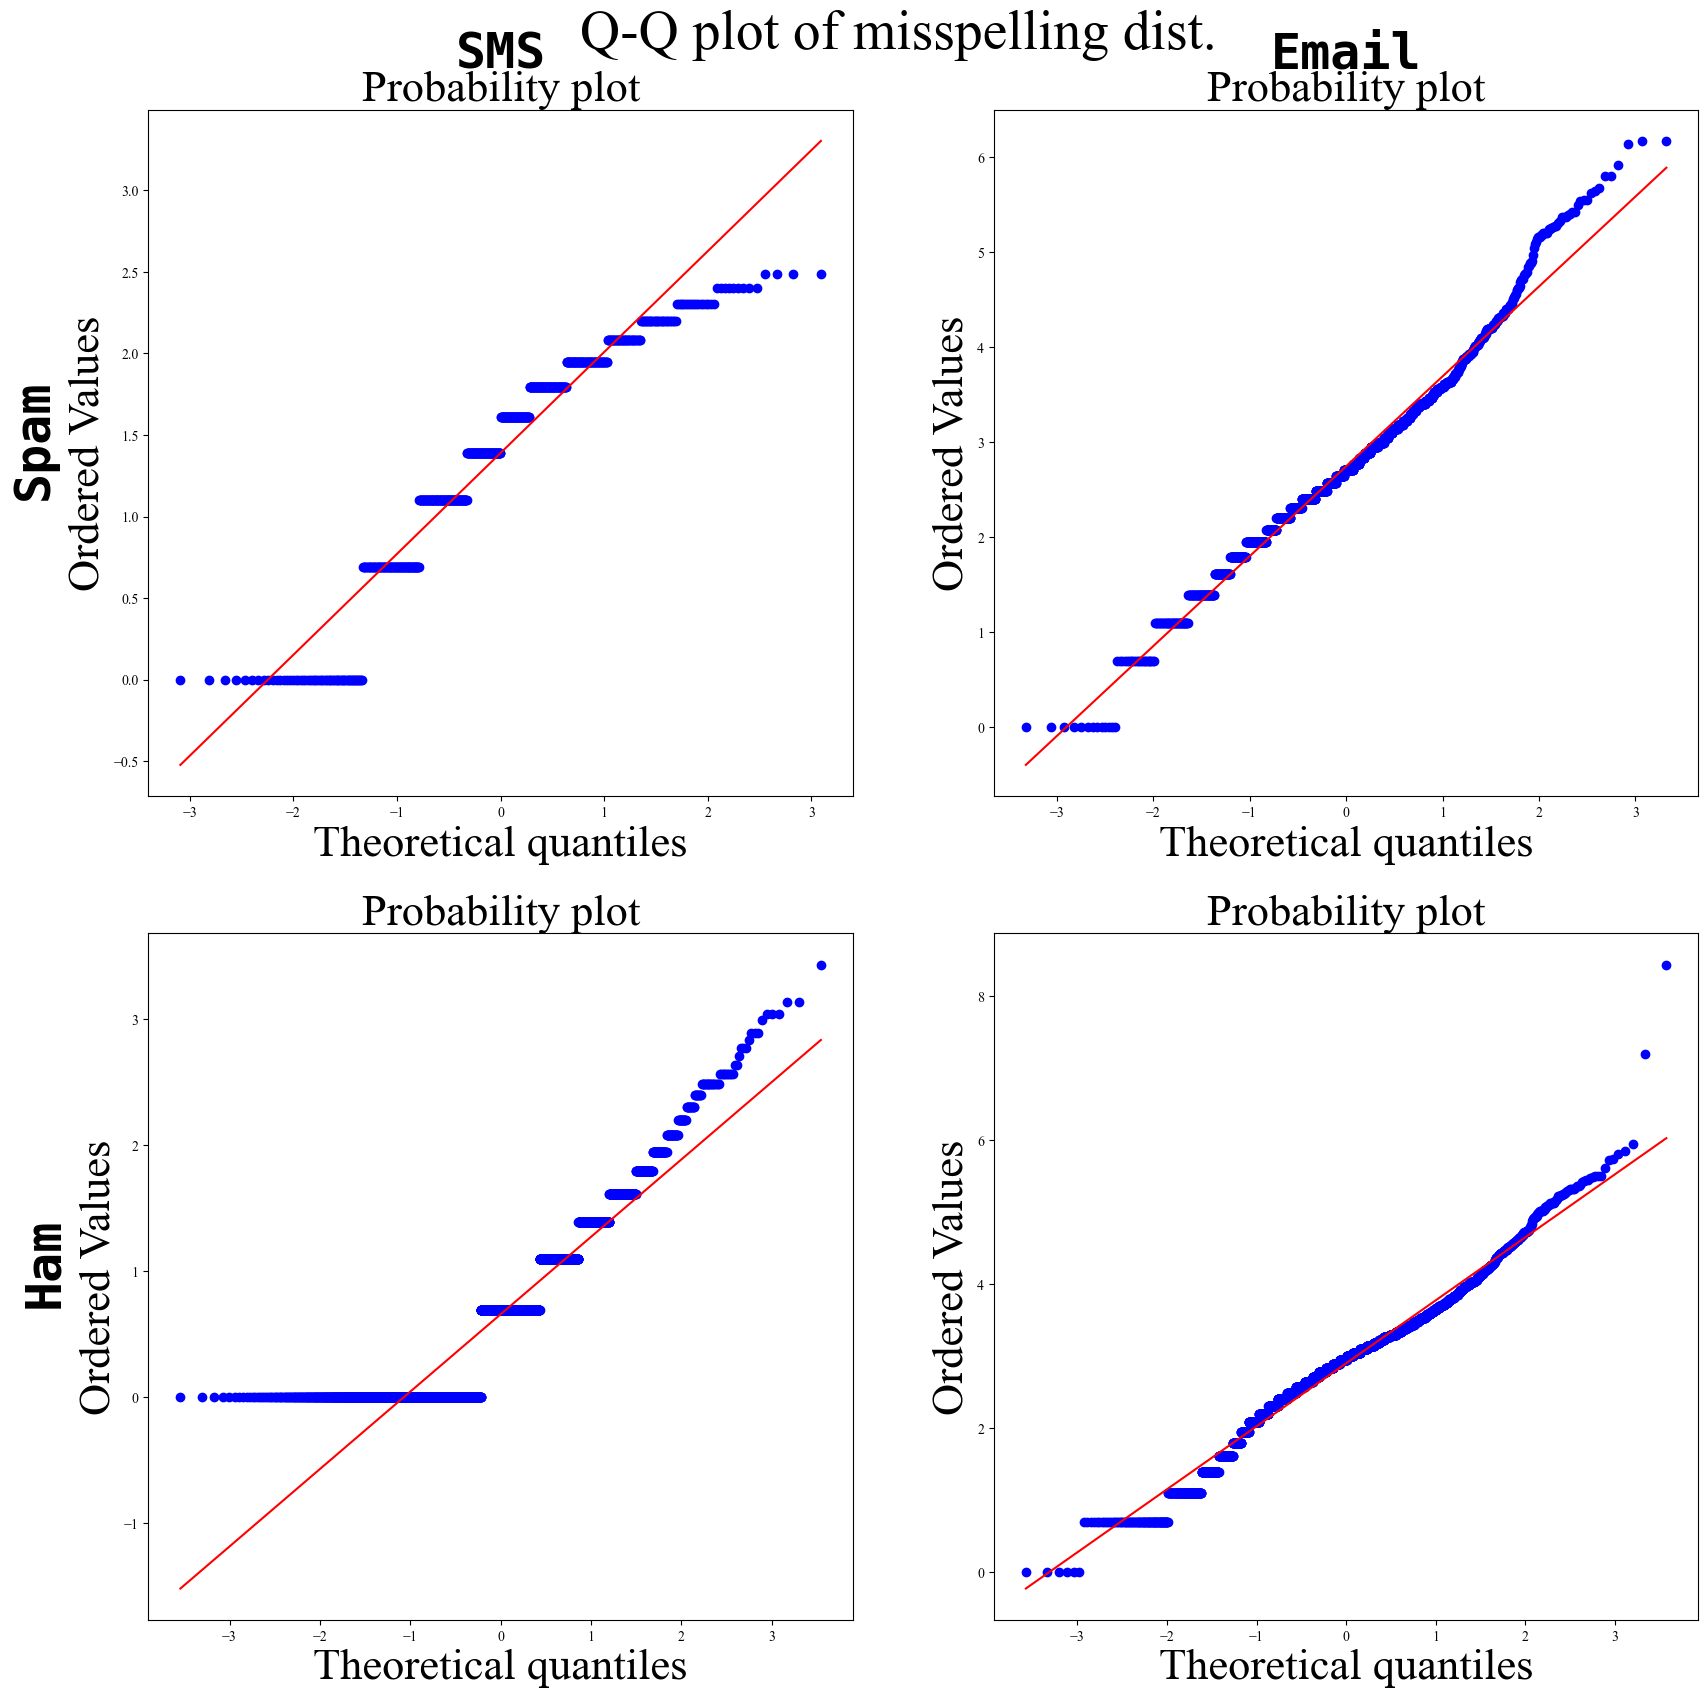

In [26]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 20), dpi=100)

datasets = ['clean_spam.csv', 'clean_completeSpamAssassin.csv']*2
label = ['spam', 'spam', 'ham', 'ham']

col_headers = ['SMS', 'Email']
row_headers = ['Spam', 'Ham']


for i, ax in enumerate(axs.flat):
    lst = np.array(dfs[datasets[i]][label[i]].misspelled_size.values)
    measurements = np.log(lst[lst != 0])
    scipy.stats.probplot(measurements, dist="norm", plot=ax)
    ax.set_title("Probability plot", fontsize = 32)
    ax.set_xlabel("Theoretical quantiles", fontsize=32)
    ax.set_ylabel("Ordered Values", fontsize=32)


font_kwargs = dict(fontfamily="monospace", fontweight="bold", size = 36)
add_headers(fig, col_headers=col_headers, row_headers=row_headers, **font_kwargs)

fig.suptitle('Q-Q plot of misspelling dist.', size = 40, y=0.93)
plt.show()

As is seen, the email dataset once again follows a log normal distribution, thus when plotting the log-scale is used for easier visualization. 

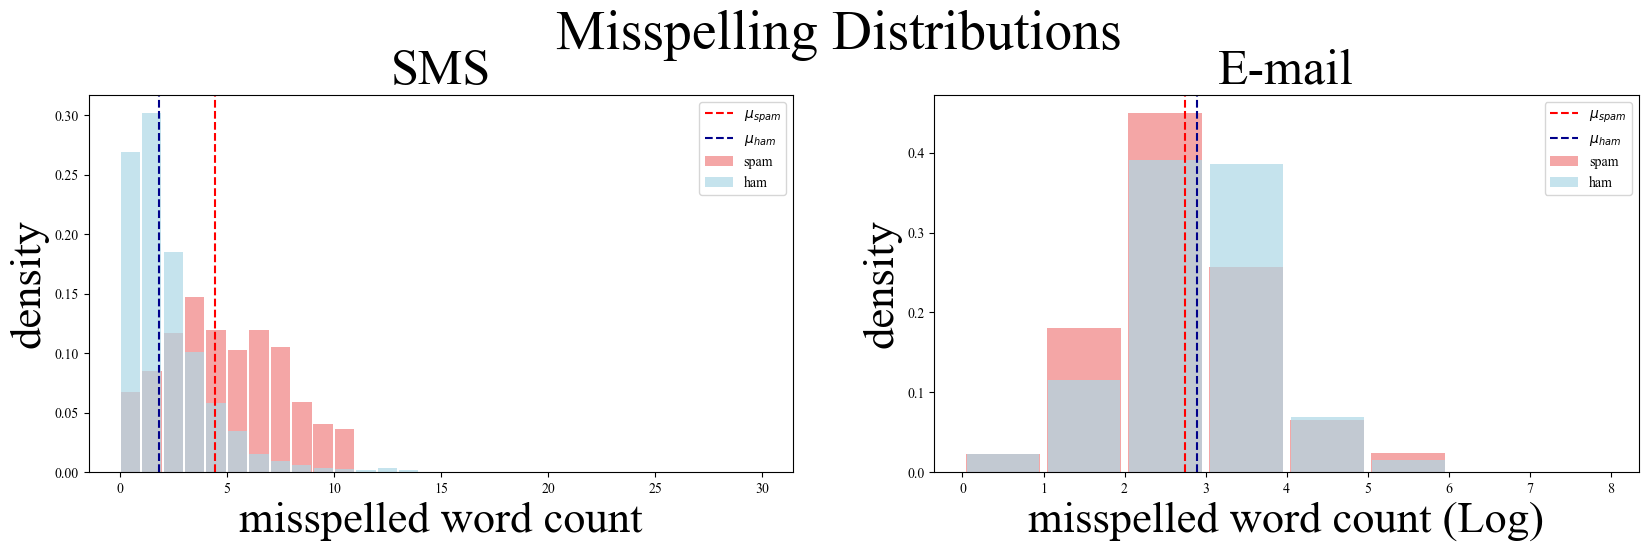

In [28]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20,5), dpi=100)
fig.subplots_adjust(hspace=0.3)

spam_lens = []
ham_lens = []

for i, ax in enumerate(axs.flat):

    spam_label = list(dfs[datasets[i]].keys())[1]
    ham_label = list(dfs[datasets[i]].keys())[2]

    if i == 1:
        lst = np.array(dfs[datasets[i]][spam_label].misspelled_size.values)
        spam_len = np.log(lst[lst != 0])
        lst = np.array(dfs[datasets[i]][ham_label].misspelled_size.values)
        ham_len = np.log(lst[lst != 0])
    else:
        spam_len = list(dfs[datasets[i]][spam_label].misspelled_size.values)
        ham_len = list(dfs[datasets[i]][ham_label].misspelled_size.values)
    
    spam_lens.append(spam_len)
    ham_lens.append(ham_len)

    bins = np.arange(min(spam_len), max(spam_len), 1)
    hist, edges = np.histogram(spam_len, bins=bins, density=True)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1]-bins[0]

    # fig, ax = plt.subplots(1, figsize=(10,5), dpi=100)
    ax.bar(x, hist, width=width*0.91, color='lightcoral', label=spam_label, alpha=0.7)
    ax.set_ylabel("counts")
    ax.set_xlabel("k")
    ax.set_title("")

    ax.axvline(np.mean(spam_len), c='red', label='$\mu_{'+spam_label+'}$', linestyle='dashed')
    ax.axvline(np.mean(ham_len), c='darkblue', label='$\mu_{'+ham_label+'}$', linestyle='dashed')

    bins = np.arange(min(ham_len), max(ham_len), 1)
    hist, edges = np.histogram(ham_len, bins=bins, density=True)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1]-bins[0]
    ax.bar(x, hist, width=width*0.90, color='lightblue', label=ham_label, alpha=0.7)

    ax.legend()
    ax.set_ylabel("density")
    ax.set_xlabel("Misspelled words")
    ax.set_title("Misspelling Distribution")
    
    ax.set_ylabel("density", fontsize = 32)
    if str(dfs[datasets[i]]['type']) == 'E-mail':
        ax.set_xlabel("misspelled word count (Log)", fontsize = 32)
        
    else: 
        ax.set_xlabel("misspelled word count", fontsize = 32)
        
    ax.set_title(str(dfs[datasets[i]]['type']), fontsize = 36) #TODO: maybe change to number of words

plt.suptitle("Misspelling Distributions", fontsize = 40, y=1.05)    

plt.show()



Descriptive statistics: 

In [ ]:
for i, dataset in enumerate(datasets[:2]):
    
    print('Dataset:', dataset)
    print()
    print(f'Mean of spam: {np.mean(spam_lens[i])}')
    print(f'Standard deviation of spam: {np.std(spam_lens[i])}')
    print()
    print(f'Mean of ham: {np.mean(ham_lens[i])}')
    print(f'Standard deviation of ham: {np.std(ham_lens[i])}')
    print()
    print()

The following section will analyse the most commonly misspelled words within each category, in order to create word clouds. 

In [ ]:
spam_freq_dist = {}
ham_freq_dist = {}

for ds in datasets[:2]:
    spam_label = list(dfs[ds].keys())[1]
    ham_label = list(dfs[ds].keys())[2]
    spam_freq_dist[ds] = nltk.FreqDist(dfs[ds][spam_label].misspelled.explode().values)
    ham_freq_dist[ds] = nltk.FreqDist(dfs[ds][ham_label].misspelled.explode().values)


In [ ]:
for (key, value) in spam_freq_dist.items():
    spam_freq_dist[key] = {k: v for k, v in sorted(value.items(), key=lambda item: item[1], reverse=True)  if not type(k) == float}

for (key, value) in ham_freq_dist.items():
    ham_freq_dist[key] = {k: v for k, v in sorted(value.items(), key=lambda item: item[1], reverse=True)  if not type(k) == float}



In [ ]:
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

Now plotting the most frequently misspelled words.

In [ ]:
k=50

for ds in datasets[:2]:    

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20,10),dpi=100)
    
    spam_ham = [ham_freq_dist[ds], spam_freq_dist[ds]]
    labels = [list(dfs[datasets[i]].keys())[1], list(dfs[datasets[i]].keys())[2]]
    colors = ['lightblue', 'coral']

    for i, ax in enumerate(axs.flat):

        ax.bar(list(spam_ham[i].keys())[:k], list(spam_ham[i].values())[:k], color=colors[i])
        ax.title.set_text(labels[i])
        ax.tick_params(axis="x", labelsize=12, rotation=90)
        
    fig.suptitle(dfs[ds]['type'], fontsize=30)
    
    plt.savefig('wordfreq_'+dfs[ds]['type']+'.png')
    plt.show()

And finally the word clouds. Each word-cloud is colored according to the spam/ham category. 

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", width=1600, height=800, colormap="Oranges")

for ds in datasets[:2]:
    spam_cloud = wordcloud.generate_from_frequencies(frequencies=spam_freq_dist[ds])

    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(spam_cloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title('Misspelled words (spam)')
    plt.savefig('misspell_spam_'+dfs[ds]['type']+'.png')
    plt.show()

In [ ]:
wordcloud = WordCloud(background_color="white", width=1600, height=800, colormap="Blues")

for ds in datasets[:2]:
    ham_cloud = wordcloud.generate_from_frequencies(frequencies=ham_freq_dist[ds])

    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(ham_cloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title('Misspelled words (ham)')
    plt.savefig('misspell_ham_'+dfs[ds]['type']+'.png')
    plt.show()